In [67]:
import cv2
import os
from modules_segmentation import *
import pandas as pd
import numpy as np

In [68]:
#get images info
image_folder = "/user/christoph.wald/u15287/big-scratch/02_splitted_data/train_labeled/images_uncropped"
image_files = os.listdir(image_folder)
image_file = image_files[3]

In [69]:
#load mask
processed_mask = cv2.imread(
    "/user/christoph.wald/u15287/insect_pest_detection/2_4_image_processing/masks/04_generated_mask_fat.jpg", 
    cv2.IMREAD_GRAYSCALE
)
original_mask = cv2.imread(
    "/user/christoph.wald/u15287/big-scratch/00_uncropped_dataset/YSTohneInsekten/IMG_5885.JPG")

gridcorners = np.load("/user/christoph.wald/u15287/insect_pest_detection/2_4_image_processing/masks/gridcorners.npy")

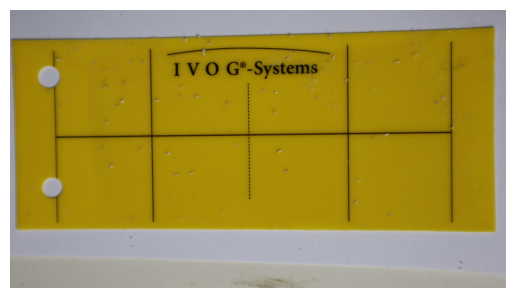

In [70]:
#load image
image = cv2.imread(os.path.join(image_folder, image_file))
#show
show(image)

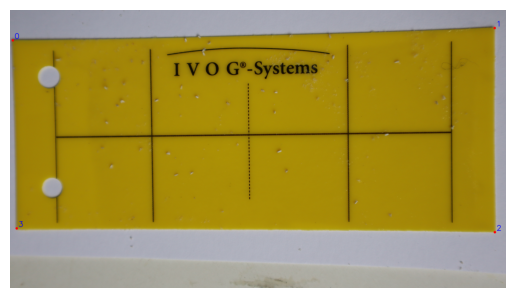

In [71]:
#find YST contour and its corners
imageYST = find_contour(image)
imagecorners = find_corners(image, imageYST)
#show
show(draw_corners(image, imagecorners))


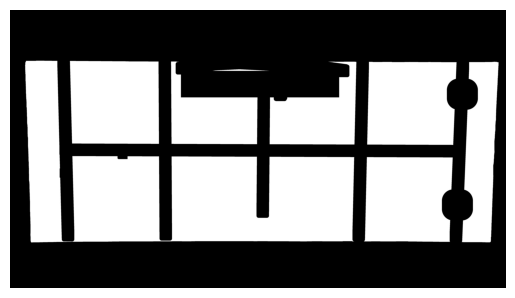

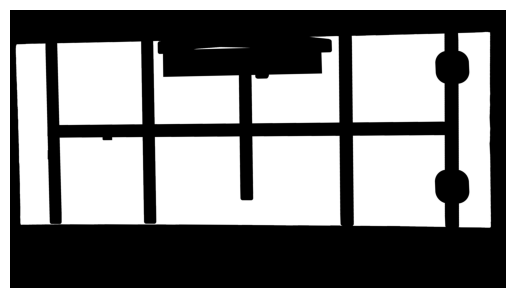

In [72]:

#find transformation
H, _ = cv2.findHomography(gridcorners, imagecorners, cv2.RANSAC)
#transform mask
mask = cv2.warpPerspective(processed_mask, H, (image.shape[1], image.shape[0]))
#only for later demonstration
original_mask_transformed = cv2.warpPerspective(create_binary_mask(original_mask), H, (image.shape[1], image.shape[0]))
#show
show(processed_mask)
show(mask)

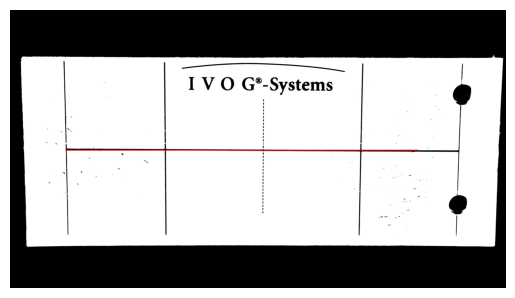

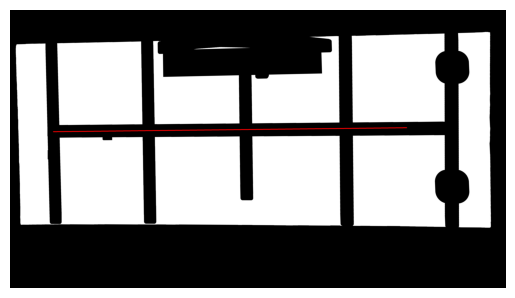

In [73]:
 #get midline from original mask image and transform as above to fit on the transformed mask
x1, y1, x2, y2 = get_h_mid(create_binary_mask(original_mask))

h_line_pts = np.array([
    [x1, y1],
    [x2, y2]
], dtype=np.float32).reshape(-1,1,2)
h_line_pts_warped = cv2.perspectiveTransform(h_line_pts, H)
x1w, y1w, x2w, y2w = h_line_pts_warped.reshape(-1).astype(np.int32)
mask_h = (x1w, y1w, x2w, y2w)
#show
show(check_h_line(create_binary_mask(original_mask), (x1,y1,x2,y2)))
show(check_h_line(mask, mask_h))

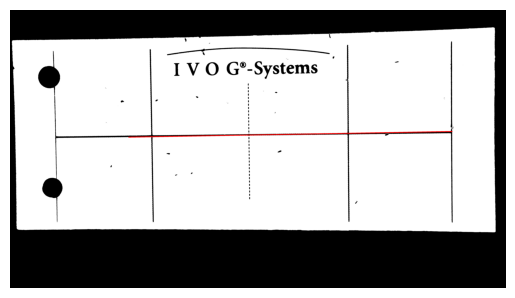

Distance: 55.5


In [74]:
#get midline for image and distance of the midlines
image_h = get_h_mid(create_binary_mask(image))
dy = get_midpoint(image_h)- get_midpoint(mask_h)
#show
show(check_h_line(create_binary_mask(image), image_h))
print(f"Distance: {dy}")

In [ ]:
#include the dy threshold

In [75]:
#second transformation / vertical correction
H, W = mask.shape[:2]
M = np.float32([[1, 0, 0], [0, 1, dy]])  # translation matrix
shifted_mask= cv2.warpAffine(mask, M, (W, H), borderValue=255)  # white background
#not easily visible but see below for effect

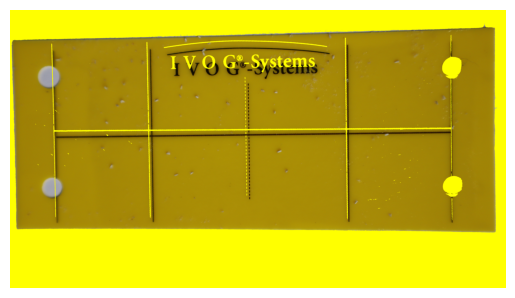

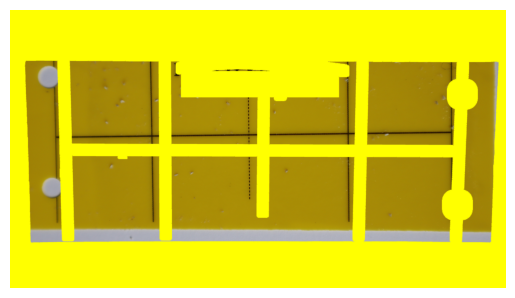

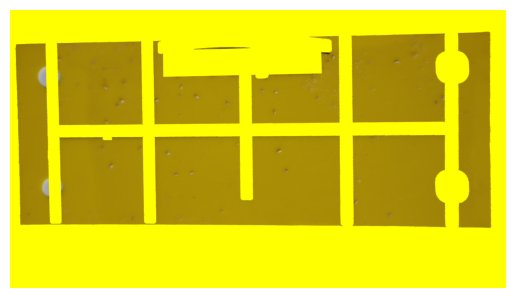

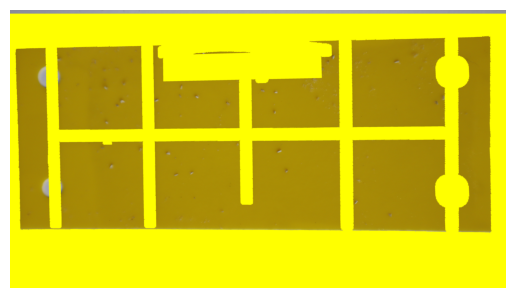

In [76]:
def create_masked_image(mask_to_use, image):
    yellow_mask = mask_to_use == 0
    image_wo_grid = image.copy()
    image_wo_grid[yellow_mask] =  [0, 255, 255]
    return image_wo_grid

masked_with_empty_YST = create_masked_image(original_mask_transformed, image)
masked_with_preprocessed_mask = create_masked_image(processed_mask, image)
masked_with_transformed_mask = create_masked_image(mask, image)
image_wo_grid = create_masked_image(shifted_mask, image)
#show
show(masked_with_empty_YST)
show(masked_with_preprocessed_mask)
show(masked_with_transformed_mask)
show(image_wo_grid)

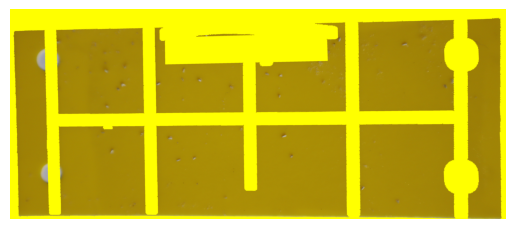

In [77]:
#crop the image
x, y, w, h = cv2.boundingRect(imageYST)
cropped_image_wo_grid = image_wo_grid[y:y+h, x:x+w]
#show
show(cropped_image_wo_grid)

43 bounding boxes found.


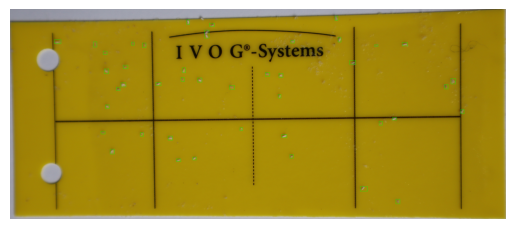

In [78]:
#manual labels on the cropped image
#green boxes for ground truth
label_folder = "/user/christoph.wald/u15287/big-scratch/02_splitted_data/train_labeled/labels_uncropped"
label_file = os.path.splitext(image_file)[0] + ".txt"
label_path = os.path.join(label_folder, label_file)
with open(label_path, "r") as f:
    yolo_labels = f.read().splitlines()
yolo_rectangles = yolo_labels_to_rectangles(yolo_labels, image.shape)
cropped_yolo_rectangles = transform_rectangles_to_cropped(yolo_rectangles, x, y,  w,h)
image_cropped = image[y:y+h, x:x+w]
image_labels = draw_bounding_boxes(image_cropped, cropped_yolo_rectangles, color = (0,255,0))
show(image_labels)

In [79]:
#estimated features for filtering bounding boxes
if "TRIAVA" in image_file:
    min_area = 100  
    max_area = 1000 
else:
    min_area = 1000 
    max_area = 10000 

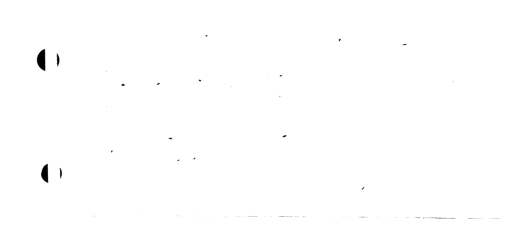

In [80]:
#this is image that is segmented
show(create_binary_mask(cropped_image_wo_grid))

9 bounding boxes found.


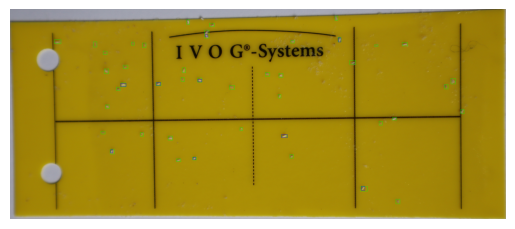

In [81]:
rectangles, _ = get_list_of_rectangles(cropped_image_wo_grid, min_area, max_area, scale = 1.5, max_ratio = 2)

image_labels = draw_bounding_boxes(image_labels, rectangles)
show(image_labels)

In [82]:
rectangles = [(x, y, x + w, y + h) for (x, y, w, h) in rectangles]
cropped_yolo_rectangles = [(x, y, x + w, y + h) for (x, y, w, h) in cropped_yolo_rectangles]
metrics, fp_boxes = evaluate_detections(rectangles, cropped_yolo_rectangles)
print(metrics)
print(f"Number of false positives: {len(fp_boxes)}")



{'TP': 9, 'FP': 0, 'FN': 34}
Number of false positives: 0


In [84]:
#Better filters
if "TRIAVA" in image_file:
    min_area_contour = 100  
    max_area_contour = 1000
    scale = 1.5
    max_ratio = 2
    upper_limit_rectangles = None
    lower_limit_rectangles = None
    value_threshold = 133  #133: 5th percentile
elif "LIRIBO" in image_file: 
    min_area_contour = 1000 
    max_area_contour = 10000 
    scale = 1.5
    max_ratio = 1.62 #90th percentile
    upper_limit_rectangles = 28626 #95th percentile
    lower_limit_rectangles = None
    value_threshold = None
elif "BRAIIM" in image_file:
    min_area_contour = 2000 
    max_area_contour = 10000
    scale = 1.5
    max_ratio = 1.59 #90the percentile
    upper_limit_rectangles = 43210 #95th percentil
    lower_limit_rectangles = 7788 #5th percentile
    value_threshold = None

rectangles, _ = get_list_of_rectangles(cropped_image_wo_grid, min_area_contour, max_area_contour, scale, max_ratio, upper_limit_rectangles, lower_limit_rectangles, value_threshold)
    
if "TRIAVA" in image_file:
    rectangles = remove_smaller_overlaps(rectangles)

9 bounding boxes found.


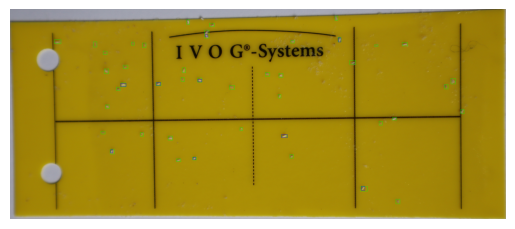

{'TP': 9, 'FP': 0, 'FN': 34}
Number of false positives: 0


In [85]:
image_labels = draw_bounding_boxes(image_labels, rectangles)
show(image_labels)
rectangles = [(x, y, x + w, y + h) for (x, y, w, h) in rectangles]
cropped_yolo_rectangles = [(x, y, x + w, y + h) for (x, y, w, h) in cropped_yolo_rectangles]
metrics, fp_boxes = evaluate_detections(rectangles, cropped_yolo_rectangles)
print(metrics)
print(f"Number of false positives: {len(fp_boxes)}")
